In [0]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict

# Data Preparation

In [3]:
class_name = 'Occupancy'

dataset_path="/content/drive/Shared drives/DM2/files/rebalanced/nearmiss.csv"
df = pd.read_csv(dataset_path)


df.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,9.469954,9.966601,6.374135,6.632908,9.512220,0
1,11.171032,8.952904,6.327000,8.070624,9.182671,0
2,12.028968,7.593496,5.949919,5.552938,8.142044,0
3,11.171032,8.929466,6.327000,7.998497,9.159434,0
4,11.466872,9.662743,7.050186,8.973232,10.004444,0


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def prepare_dataset(df, class_name):
    df = remove_missing_values(df)
    numeric_columns = get_numeric_columns(df)
    rdf = df.copy(deep=True)
    df, feature_names, class_values = one_hot_encoding(df, class_name)
    real_feature_names = get_real_feature_names(rdf, numeric_columns, class_name)
    rdf = rdf[real_feature_names + (class_values if isinstance(class_name, list) else [class_name])]
    features_map = get_features_map(feature_names, real_feature_names)

    return df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map

def remove_missing_values(df):
    for column_name, nbr_missing in df.isna().sum().to_dict().items():
        if nbr_missing > 0:
            if column_name in df._get_numeric_data().columns:
                mean = df[column_name].mean()
                df[column_name].fillna(mean, inplace=True)
            else:
                mode = df[column_name].mode().values[0]
                df[column_name].fillna(mode, inplace=True)
    return df

def get_numeric_columns(df):
    numeric_columns = list(df._get_numeric_data().columns)
    return numeric_columns

def get_real_feature_names(rdf, numeric_columns, class_name):
    real_feature_names = [c for c in rdf.columns if c in numeric_columns and c != class_name]
    real_feature_names += [c for c in rdf.columns if c not in numeric_columns and c != class_name]
    return real_feature_names

def one_hot_encoding(df, class_name):
    dfX = pd.get_dummies(df[[c for c in df.columns if c != class_name]], prefix_sep='=')
    class_name_map = {v: k for k, v in enumerate(sorted(df[class_name].unique()))}
    dfY = df[class_name].map(class_name_map)
    df = pd.concat([dfX, dfY], axis=1)
    feature_names = list(dfX.columns)
    class_values = sorted(class_name_map)
    return df, feature_names, class_values

def get_features_map(feature_names, real_feature_names):
    features_map = defaultdict(dict)
    i = 0
    j = 0

    while i < len(feature_names) and j < len(real_feature_names):
        if feature_names[i] == real_feature_names[j]:
            features_map[j][feature_names[i]] = j
            i += 1
            j += 1
        elif feature_names[i].startswith(real_feature_names[j]):
            features_map[j][feature_names[i]] = j
            i += 1
        else:
            j += 1
    return features_map

In [6]:
res = prepare_dataset(df, class_name)
df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map = res
df.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,9.469954,9.966601,6.374135,6.632908,9.512220,0
1,11.171032,8.952904,6.327000,8.070624,9.182671,0
2,12.028968,7.593496,5.949919,5.552938,8.142044,0
3,11.171032,8.929466,6.327000,7.998497,9.159434,0
4,11.466872,9.662743,7.050186,8.973232,10.004444,0


# Data Partitioning

In [0]:
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [0]:
attributes = [col for col in df.columns if col != class_name]
X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

# Linear *Regression* 

Coefficients: 
 [0.92768511]
   
R2: 0.889044
Mean squared error: 1.142474
Mean Absolute error:
0.8476043294232928


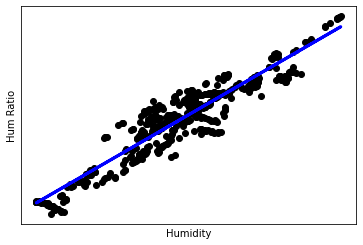

In [9]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets, linear_model

Hum = df['Humidity'].values
Hum_R = df['HumidityRatio'].values

Hum_X_train, Hum_X_test, Hum_y_train, Hum_y_test = train_test_split(Hum, Hum_R, test_size=0.3, random_state=100)

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(Hum_X_train.reshape(-1, 1), Hum_y_train)

# Make predictions using the testing set
Hum_y_pred = regr.predict(Hum_X_test.reshape(-1, 1))

# The coefficients
print('Coefficients: \n', regr.coef_)
print('   ')

# The coefficient of determination: 1 is perfect prediction
print('R2: %.6f'
      % r2_score(Hum_y_test, Hum_y_pred))
# The mean squared error
print('Mean squared error: %.6f'
      % mean_squared_error(Hum_y_test, Hum_y_pred))

print('Mean Absolute error:')
print(mean_absolute_error(Hum_y_test, Hum_y_pred))

# Plot outputs
plt.scatter(Hum_X_test, Hum_y_test,  color='black')
plt.plot(Hum_X_test, Hum_y_pred, color='blue', linewidth=3)
plt.xlabel('Humidity')
plt.ylabel('Hum Ratio')

plt.xticks(())
plt.yticks(())

plt.show()

Lasso

In [10]:
alfa = [1e-4,1e-3,1e-2,1e-1,1,1e2,1e3,1e4]
reg = linear_model.LassoCV(alphas=alfa)
reg.fit(Hum_X_train.reshape(-1, 1), Hum_y_train)
print('Best value of alpha= %f' % reg.alpha_)
print('   ')

from sklearn import linear_model
reg = linear_model.Lasso(alpha=0.0001)
reg.fit(Hum_X_train.reshape(-1, 1), Hum_y_train)
print('Coefficients: \n', reg.coef_)
print('Intercept: \n', reg.intercept_)
print('   ')

y_pred = reg.predict(Hum_X_test.reshape(-1, 1))
print('R2: %.6f' % r2_score(Hum_y_test, Hum_y_pred))
print('MSE: %.6f' % mean_squared_error(Hum_y_test, Hum_y_pred))
print('MAE: %.6f' % mean_absolute_error(Hum_y_test, Hum_y_pred))
print('   ')

Best value of alpha= 0.000100
   
Coefficients: 
 [0.92767559]
Intercept: 
 0.6336381664468629
   
R2: 0.889044
MSE: 1.142474
MAE: 0.847604
   


Ridge

fondamentale trovare valori di penalità, trovo il miglior valore di alpha

In [11]:
alfa = [1e-4,1e-3,1e-2,1e-1,1,1e2,1e3,1e4]
reg = linear_model.RidgeCV(alphas=alfa, store_cv_values=True)
reg.fit(Hum_X_train.reshape(-1, 1), Hum_y_train)
print('Best value of alpha= %f' % reg.alpha_)
print('   ')

reg = linear_model.Ridge(alpha=1)
reg.fit(Hum_X_train.reshape(-1,1), Hum_y_train.reshape(-1,1))
print('Coefficients: \n', reg.coef_)
print('Intercept: \n', reg.intercept_)
print('   ')

y_pred = reg.predict(Hum_X_test.reshape(-1,1))
print('R2: %.6f' % r2_score(Hum_y_test, Hum_y_pred))
print('MSE: %.6f' % mean_squared_error(Hum_y_test, Hum_y_pred))
print('MAE: %.6f' % mean_absolute_error(Hum_y_test, Hum_y_pred))
print('   ')

Best value of alpha= 0.000100
   
Coefficients: 
 [[0.92762201]]
Intercept: 
 [0.63416177]
   
R2: 0.889044
MSE: 1.142474
MAE: 0.847604
   


Elastic Net

In [12]:
alfa = [1e-4,1e-3,1e-2,1e-1,1,1e2,1e3,1e4]
reg = linear_model.ElasticNetCV(alphas=alfa,max_iter=10000)
reg.fit(Hum_X_train.reshape(-1,1), Hum_y_train)
print('Best value of alpha= %f' % reg.alpha_)
print('   ')

reg = linear_model.ElasticNet(alpha=0.0001, max_iter=1000000)
reg.fit(Hum_X_train.reshape(-1,1), Hum_y_train.reshape(-1,1))
print('Coefficients: \n', reg.coef_)
print('Intercept: \n', reg.intercept_)
print('   ')

y_pred = reg.predict(Hum_X_test.reshape(-1,1))
print('R2: %.6f' % r2_score(Hum_y_test, Hum_y_pred))
print('MSE: %.6f' % mean_squared_error(Hum_y_test, Hum_y_pred))
print('MAE: %.6f' % mean_absolute_error(Hum_y_test, Hum_y_pred))

Best value of alpha= 0.000100
   
Coefficients: 
 [0.92767593]
Intercept: 
 [0.6336348]
   
R2: 0.889044
MSE: 1.142474
MAE: 0.847604


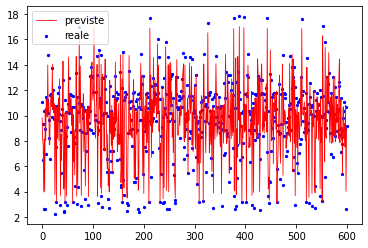

In [13]:
x_ax = range(len(Hum_X_test))
plt.scatter(x_ax, Hum_y_test, s=5, color='blue', label='reale')
plt.plot(x_ax, Hum_y_pred, lw=0.8, color='red', label='previste')
plt.legend()
plt.show()

# Multiple Linear Regression

simple multiple linear regression

In [14]:
df.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,9.469954,9.966601,6.374135,6.632908,9.512220,0
1,11.171032,8.952904,6.327000,8.070624,9.182671,0
2,12.028968,7.593496,5.949919,5.552938,8.142044,0
3,11.171032,8.929466,6.327000,7.998497,9.159434,0
4,11.466872,9.662743,7.050186,8.973232,10.004444,0


In [0]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [16]:
reg = LinearRegression()
reg.fit(X_train, y_train)

print('Coefficients: \n', reg.coef_)
print('Intercept: \n', reg.intercept_)
print('   ')

y_pred = reg.predict(X_test)

print('R2: %.6f' % r2_score(y_test, y_pred))
print('MSE: %.6f' % mean_squared_error(y_test, y_pred))
print('MAE: %.6f' % mean_absolute_error(y_test, y_pred))

Coefficients: 
 [-0.07159915 -0.09376781  0.19533609  0.05200284  0.10805376]
Intercept: 
 -0.24691888396120393
   
R2: 0.589312
MSE: 0.102654
MAE: 0.250777


lasso multiple linear regression

In [17]:
alfa = [1e-4,1e-3,1e-2,1e-1,1,1e2,1e3,1e4]
reg = linear_model.LassoCV(alphas=alfa, max_iter=10000)
reg.fit(X_train, y_train)
print('Best value of alpha= %f' % reg.alpha_)
print('   ')

reg = linear_model.Lasso(alpha=0.0001, max_iter=10000)
reg.fit(X_train,y_train)
print('Coefficients: \n', reg.coef_)
print('Intercept: \n', reg.intercept_)
print('   ')

y_pred = reg.predict(X_test)
print('R2: %.6f' % r2_score(y_test, y_pred))
print('MSE: %.6f' % mean_squared_error(y_test, y_pred))
print('MAE: %.6f' % mean_absolute_error(y_test, y_pred))

Best value of alpha= 0.000100
   
Coefficients: 
 [-0.06660726 -0.08131375  0.19489305  0.05235093  0.09482131]
Intercept: 
 -0.2917356643031241
   
R2: 0.588964
MSE: 0.102741
MAE: 0.250927


ridge multiple linear regression

In [18]:
alfa = [1e-4,1e-3,1e-2,1e-1,1,1e2,1e3,1e4]
reg = linear_model.RidgeCV(alphas=alfa, store_cv_values=True)
reg.fit(X_train, y_train)
print('Best value of alpha= %f' % reg.alpha_)
print('   ')

reg = Ridge(alpha=1)
reg.fit(X_train, y_train)
print('Coefficients: \n', reg.coef_)
print('Intercept: \n', reg.intercept_)
print('   ')

y_pred = reg.predict(X_test)
print('R2: %.6f' % r2_score(y_test, y_pred))
print('MSE: %.6f' % mean_squared_error(y_test, y_pred))
print('MAE: %.6f' % mean_absolute_error(y_test, y_pred))

Best value of alpha= 1.000000
   
Coefficients: 
 [-0.06839522 -0.08579132  0.19499737  0.05224864  0.09956331]
Intercept: 
 -0.2753773800633685
   
R2: 0.589088
MSE: 0.102710
MAE: 0.250881


elastic net multiple linear regression

In [19]:
alfa = [1e-4,1e-3,1e-2,1e-1,1,1e2,1e3,1e4]
reg = linear_model.ElasticNetCV(alphas=alfa,max_iter=10000)
reg.fit(X_train, y_train)
print('Best value of alpha= %f' % reg.alpha_)
print('   ')

reg = linear_model.ElasticNet(alpha=0.0001, max_iter=10000)
reg.fit(X_train, y_train)
print('Coefficients: \n', reg.coef_)
print('Intercept: \n', reg.intercept_)
print('   ')

y_pred = reg.predict(X_test)
print('R2: %.6f' % r2_score(y_test, y_pred))
print('MSE: %.6f' % mean_squared_error(y_test, y_pred))
print('MAE: %.6f' % mean_absolute_error(y_test, y_pred))

Best value of alpha= 0.000100
   
Coefficients: 
 [-0.06887598 -0.08697505  0.19509062  0.0521943   0.10083536]
Intercept: 
 -0.27134598171042107
   
R2: 0.589125
MSE: 0.102700
MAE: 0.250859
